<a href="https://colab.research.google.com/github/kylianmbappe9/Xanadu-CodeBook/blob/main/Data_reuploading_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#\\ **Main Objective: **

#classifying whether the points that we have assigned are inside or outside a given, or drawn 2D plane

In [99]:
from google.colab import files
uploaded = files.upload()

Saving universal_circles.png to universal_circles (10).png


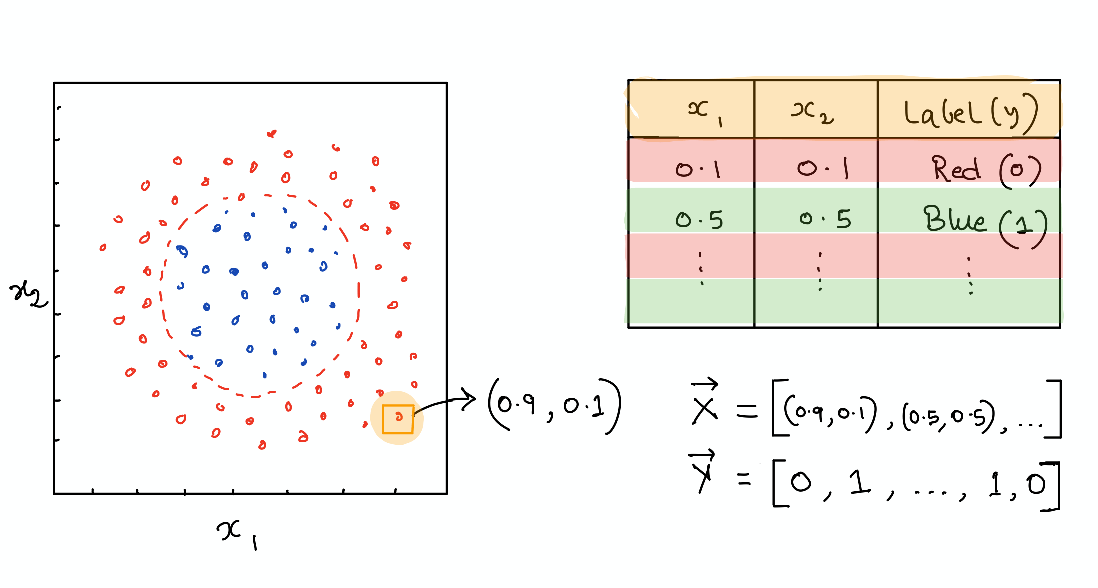

In [100]:
from google.colab.patches import cv2_imshow
import cv2 as cv

# Read the image (make sure the image file is uploaded to Colab or use the correct path)
image = cv.imread("/content/universal_circles.png")

# Show the image
cv2_imshow(image)


#on the image above, we have a 2D plane and randomly assigned Blue Points and Red points on a 2D plane. Points inside the circle are considered 1 and points outside the circle are 0.

##we want to train the model on whether the chosen point lies inside or outside thc circle by inputting the coordinates to our quanutm circuit. For that we would want to train the quantum circuit

#1) Quantum State Representation:

A single-qubit quantum state is represented by a vector in a two-dimensional space.
This state can be visualized on the Bloch sphere, which is a 3D representation.

#2) Basic States:

|0⟩: Represented as the "up" state.
|1⟩: Represented as the "down" state.

#3)Superposition:

A qubit can exist in a combination of |0⟩ and |1⟩.
For example, a qubit might have a 30% chance of being in state |0⟩ and a 70% chance of being in state |1⟩.

In [101]:
!pip install pennylane

#first we import the necessary modules and set a safe seed value so when you run the code nexct time, we still get the same output

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane
from pennylane import numpy as np

np.random.seed(100)

#pretty straightforward code where we have defined the function circle with its number of samples, the centre coordinate and the radius of the circle

#we have created the X_value lists and Y_value lists empty so as to eeverytime we update the coordinate and whatever value (random value with mean 0 and gaussian distribuion of 1) lies that will be appended in our x_val list and y qill also be appended in the y value list.

#for the y, if the euclidian distance(x - centre) is less than radius, 0 will be appended and if greater, 1 will be appeneded but regardless of what the condition states the values will always be appended

In [103]:
def circle(sample, centre=[0.0, 0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    X_vals = []
    Y_vals = []

    for i in range(sample):
        x = (2 * (np.random.rand(2)) - 1)  # Generates a 2D point
        y = 0
        if np.linalg.norm(x) < radius:  # Checks if point is inside the circle
            y = 1  # Label as 1 (inside the circle)
        else:
            y = 0  # Label as 0 (outside the circle)

        X_vals.append(x)
        Y_vals.append(y)

    # Ensure X_vals and Y_vals are returned as NumPy arrays
    return np.array(X_vals, dtype=np.float64, requires_grad=False), np.array(Y_vals, dtype=np.float64, requires_grad=False)


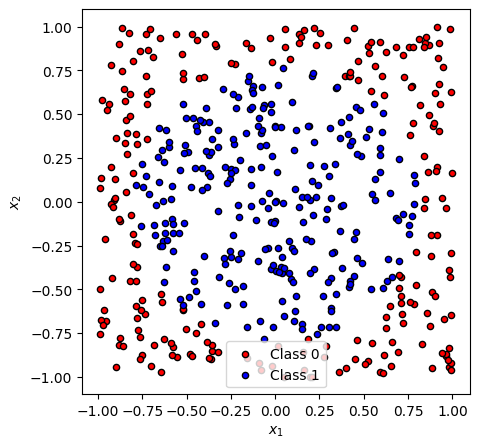

In [104]:
def plot_data(x, y, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    red = y == 0
    blue = y == 1

    ax.scatter(x[red][:, 0], x[red][:, 1], c="red", s=20, edgecolor="k", label="Class 0")
    ax.scatter(x[blue][:, 0], x[blue][:, 1], c="blue", s=20, edgecolor="k", label="Class 1")

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    #I hope to be a great husband
    ax.legend()
    #wishing to be a great father hoipefully
    return fig, ax

Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


**#THE FIRST TWO FUNCTIONS WHERE MOSTLY ON CREATING A FUNCTION AND PLOTTING DATA**

#Density matrix here is just multiplting the compelx noatations where if we lets say find the probability density

##|PSI**2| = <PSI><PSI| or <PSI|PSI>

#complex conjudgate so we multiply the original matrix * the transposed or the conjugate of the orignal matrix



In [105]:
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]] # Corresponds to state |0>
label_1 = [[0], [1]] # Corresponds to state |1>
state_labels = np.array([label_0, label_1], requires_grad=False)

#Simple classifier with data reloading and fidelity loss
**bold text**

so technically x and p is represented as [theta_x = some_angle_value theta_y = some_angle_value, theta_z = some_angle_value]

In [107]:
import pennylane as qml
dev = qml.device("lightning.qubit", wires=1)


@qml.qnode(dev)
def qcircuit(params, x, y):
    #ere we created a quantum circuit where we have set the qml device we will
    #be using to simulate our backend simulator
    #now inside out circuit we have the x input values and the y output values
    #and it is parametarized so we have set of parameters [since it is ansatz]
    #so every parameter will output every specific measyurement value
    #and go back to the input circuit [it is unitary meaning the output is ]
    #[similar to the input and so everytime the value is output, the input value will]
    #use the output value as the input value and parametarzie the reused
    #output value.
    #After all the process and stuff, we will get the final expectation / average
    #value and for y, [the only reason we will output a hermitian is becase we want
    # to ensure that the original output matrix is the same as the conjugate of the
    #original matrix by the hermitian rule]
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    #here x denotes a 2D parameter because X input
    #is a coordinate input (0.9, 0.1) and
    #y is the final output (0[red or 1[blue]])
    #so unlike X which inputs as coordinates
    #y will output a single digit value corresponsing
    #to whether the output is blue or red

    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)





#main aim of this cost function is that we have the input parameters x, y, parameters, state_labels where x dentes the 2D array coordiante of wheere that specific point exists (example": [0.9, 0.1] this denotes our x input and y[0 (red) or 1(blue)]. From here on because Y will outpuit the final label (whether its red or blue) we know that Y will go through a density matrix, [Transposerd matrix * Original Matrix = Identity Matrix] and for every input we assign a aparameter

f = qcircuit(parameters, x[i], df_labels[y[i]])

EXAMPLE

I = 1
PARAMETER(s) = 1
X[1] = 0.9, 0.3
Y[1] = 1 (BLUE)

----------> loss = loss + (1 - f) ** 2

---------> RETURNS TO THE INPUT

----------> PARAMETER(S) = 2
X[2] = -0.8, 0.5
Y[2] = 0 (RED)
----------> loss = loss + (1 - f) ** 2

---------> RETURNS TO THE INPUT

----------> PARAMETER(S) = 3

AND SO ON

## return loss / len(x) THIS IS THE ENTIRE LOSS FUNCTION / HOW MANY PARAMETERS
##TO OUTPUT THE AVERAGE VALUE [EXPECTATION VALUE]

In [109]:
def cost_function(x, y, parameters, state_labels=None):
  df_labels = (density_matrtix[s] for s in range(len(state_labels)))
  loss = 0.0
  for i in range(len(x)):
    f = qcircuit(parameters, x[i], df_labels[y[i]])
    loss = loss + (1 - f) ** 2
  return loss / len(x)
